In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from functools import partial
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import optuna
from sklearn.metrics import f1_score, auc, roc_curve

from itertools import combinations

c:\Users\HyeonJinLee\Documents\dev\Upstage_AI_LAB_ML_Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
with open('./src/train.csv') as f:
    train = pd.read_csv(f)
with open('./src/test.csv') as f:
    test = pd.read_csv(f)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   user_id                            10000 non-null  object 
 1   subscription_duration              10000 non-null  int64  
 2   recent_login_time                  10000 non-null  int64  
 3   average_login_time                 10000 non-null  float64
 4   average_time_per_learning_session  10000 non-null  float64
 5   monthly_active_learning_days       10000 non-null  int64  
 6   total_completed_courses            10000 non-null  int64  
 7   recent_learning_achievement        10000 non-null  float64
 8   abandoned_learning_sessions        10000 non-null  int64  
 9   community_engagement_level         10000 non-null  int64  
 10  preferred_difficulty_level         10000 non-null  object 
 11  subscription_type                  10000 non-null  obje

In [5]:
train.head(5)

,user_id,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,customer_inquiry_history,payment_pattern,target
0,b919c29d,13,14,14.946163,8.427187,18,16,68.360455,3,4,Low,Basic,4,5,0
1,a0a60abb,16,18,18.453224,72.646087,16,13,97.567322,2,3,Medium,Basic,1,6,1
2,b9f171ae,22,1,16.195228,21.774492,13,14,94.358763,3,4,Medium,Premium,0,7,1
3,5dc0ba8b,1,19,17.628656,42.659066,19,18,70.153228,0,3,Low,Basic,1,0,1
4,65c83654,4,5,21.390656,30.744287,19,10,81.917908,2,4,Medium,Basic,3,0,1


In [6]:
# col = 'preferred_difficulty_level'
# plt.figure(figsize = (6,6))
# sns.countplot(data = train, x = col, hue = 'target', palette = 'Set3')
# plt.savefig(f'{col}.png')

In [7]:
train = train.drop(columns='user_id')
test = test.drop(columns = 'user_id')
train

,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,customer_inquiry_history,payment_pattern,target
0,13,14,14.946163,8.427187,18,16,68.360455,3,4,Low,Basic,4,5,0
1,16,18,18.453224,72.646087,16,13,97.567322,2,3,Medium,Basic,1,6,1
2,22,1,16.195228,21.774492,13,14,94.358763,3,4,Medium,Premium,0,7,1
3,1,19,17.628656,42.659066,19,18,70.153228,0,3,Low,Basic,1,0,1
4,4,5,21.390656,30.744287,19,10,81.917908,2,4,Medium,Basic,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,22,29,14.727623,84.053558,18,16,64.966803,2,5,Low,Premium,1,1,1
9996,10,11,19.374054,45.464833,9,8,82.750244,3,3,Medium,Basic,2,7,1
9997,7,27,18.240978,127.302411,24,14,81.567839,3,5,High,Basic,1,6,1
9998,11,7,18.783800,5.297234,10,10,89.885656,4,5,Low,Basic,2,0,1


In [8]:
# 근 3개월 간 구독 개월
# train.payment_pattern = train.payment_pattern.apply(lambda x: 0 if x == 0 else (1 if x in [1,2,4] else (2 if x in [3,5,6] else 3)))

# 근 1개월 구독 여부
# train.payment_pattern = train.payment_pattern.apply(lambda x: 0 if x in [0,2,4,6] else 1)

# 선호 학습 난이도 (high / basic,low)
# train.preferred_difficulty_level = train.preferred_difficulty_level.apply(lambda x: 1 if x == 'High' else 0)

In [9]:

train.payment_pattern = train.payment_pattern.astype('object', copy = False)
test.payment_pattern = test.payment_pattern.astype('object')
train.payment_pattern.value_counts()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   subscription_duration              10000 non-null  int64  
 1   recent_login_time                  10000 non-null  int64  
 2   average_login_time                 10000 non-null  float64
 3   average_time_per_learning_session  10000 non-null  float64
 4   monthly_active_learning_days       10000 non-null  int64  
 5   total_completed_courses            10000 non-null  int64  
 6   recent_learning_achievement        10000 non-null  float64
 7   abandoned_learning_sessions        10000 non-null  int64  
 8   community_engagement_level         10000 non-null  int64  
 9   preferred_difficulty_level         10000 non-null  object 
 10  subscription_type                  10000 non-null  object 
 11  customer_inquiry_history           10000 non-null  int6

In [10]:
train['average_time_per_learning_session_over_160'] = train['average_time_per_learning_session'] > 160
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   subscription_duration                       10000 non-null  int64  
 1   recent_login_time                           10000 non-null  int64  
 2   average_login_time                          10000 non-null  float64
 3   average_time_per_learning_session           10000 non-null  float64
 4   monthly_active_learning_days                10000 non-null  int64  
 5   total_completed_courses                     10000 non-null  int64  
 6   recent_learning_achievement                 10000 non-null  float64
 7   abandoned_learning_sessions                 10000 non-null  int64  
 8   community_engagement_level                  10000 non-null  int64  
 9   preferred_difficulty_level                  10000 non-null  object 
 10  subscriptio

In [11]:
# # 특정 컬럼들에 대한 이상치 확인 (이상치가 있는 컬럼들을 리스트로 지정)
# columns_of_interest = ['average_login_time', 'total_completed_courses', 'recent_learning_achievement','abandoned_learning_sessions','customer_inquiry_history']  # 실제 컬럼 이름에 맞게 수정
# # 각 컬럼에 대해 이상치를 제외한 나머지 행 유지
# for column in columns_of_interest:
#     Q1 = train[column].quantile(0.25)
#     Q3 = train[column].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     train = train[(train[column] >= lower_bound) & (train[column] <= upper_bound)]
# # 결과 출력
# print("제거 전 행의 개수:", len(pd.read_csv('./src/train.csv')))
# print("제거 후 행의 개수:", len(train))

In [12]:
cols = list(train.columns)
cols.remove('target')
cols

['subscription_duration',
 'recent_login_time',
 'average_login_time',
 'average_time_per_learning_session',
 'monthly_active_learning_days',
 'total_completed_courses',
 'recent_learning_achievement',
 'abandoned_learning_sessions',
 'community_engagement_level',
 'preferred_difficulty_level',
 'subscription_type',
 'customer_inquiry_history',
 'payment_pattern',
 'average_time_per_learning_session_over_160']

In [28]:

# X = train.loc[:,['average_time_per_learning_session','recent_learning_achievement','average_login_time']]
X = train.loc[:,['average_time_per_learning_session_over_160','average_time_per_learning_session','recent_learning_achievement','average_login_time']]
# X = train.loc[:,['average_time_per_learning_session','average_time_per_learning_session_over_160', 'monthly_active_learning_days', 'total_completed_courses', 'preferred_difficulty_level']]
# X = train.loc[:,cols]
y = train.loc[:,'target']
X = pd.get_dummies(X)
scale_pos_weight = (y==0).sum()/(y==1).sum()

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=39)

In [29]:
def optimizer2(trial, X, y, K):
    n_estimators = trial.suggest_int('n_estimators', 500, 2000)
    learning_rate = trial.suggest_float('learning_rate',0.01, 0.3)
    # max_depth = trial.suggest_int('max_depth',5,13)
    colsample_bynode = trial.suggest_float('colsample_bynode',0.5,0.8)
    reg_lambda = trial.suggest_float('reg_lambda',0.5,200)

    model = XGBClassifier(n_estimators = n_estimators,
                          learning_rate = learning_rate,
                          max_depth = 15,
                          colsample_bynode = colsample_bynode,
                          reg_lambda = reg_lambda,
                          random_state = 39,
                          verbosity  = 0)
    
    kf = StratifiedKFold(n_splits = K, random_state=39, shuffle=True)
    macrof1 = []
    for idx, (train_idx, val_idx) in enumerate(kf.split(X,y)):
        X_train = X.iloc[train_idx,:]
        X_val = X.iloc[val_idx,:]
        y_train = y.iloc[train_idx]
        y_val = y.iloc[val_idx]

        model.fit(X_train, y_train)
        prediction = model.predict(X_val)
        macrof1.append(f1_score(y_val, prediction, average= 'macro'))
    
    return np.mean(macrof1)

In [30]:
def optimizer1(trial, X, y, K):
    n_estimators = trial.suggest_int('n_estimators', 100, 2500)
    learning_rate = trial.suggest_float('learning_rate',0.01, 0.45)
    num_leaves = trial.suggest_categorical('num_leaves',[255, 511,1023,2047,4095])
    colsample_bytree = trial.suggest_float('colsample_bytree',0.35,0.9)
    reg_lambda = trial.suggest_float('reg_lambda',0.5,200)
    min_child_samples = trial.suggest_int('min_child_samples',5,50)
    # scale_pos_weight = (y==0).sum()/(y==1).sum()
    max_depth = trial.suggest_int('max_depth', 5, 15)
    min_split_gain = trial.suggest_float('min_split_gain', 0.001, 0.05)

    model = LGBMClassifier(n_estimators = n_estimators,
                          learning_rate = learning_rate,
                          max_depth = max_depth,
                          colsample_bytree = colsample_bytree,
                          num_leaves= num_leaves,
                          min_child_samples= min_child_samples,
                          reg_lambda = reg_lambda,
                          min_split_gain= min_split_gain,
                          scale_pos_weight = scale_pos_weight,
                          random_state = 39,
                          objective = 'binary',
                          verbose  = -1)
    
    kf = StratifiedKFold(n_splits = K, random_state=39, shuffle=True)
    macrof1 = []
    for idx, (train_idx, val_idx) in enumerate(kf.split(X,y)):
        X_train = X.iloc[train_idx,:]
        X_val = X.iloc[val_idx,:]
        y_train = y.iloc[train_idx]
        y_val = y.iloc[val_idx]
        

        model.fit(X_train, y_train)
        prediction = model.predict(X_val)
        macrof1.append(f1_score(y_val, prediction, average= 'macro'))
    
    return np.mean(macrof1)

In [33]:
K = 5
opt_func = partial(optimizer1, X = X, y = y, K = K)
study = optuna.create_study(direction = 'maximize')
study.optimize(opt_func, n_trials = 3000)

print(f"best score : {study.best_value:.4f}")
print(f"best params : {study.best_params}")

[I 2023-12-09 10:20:31,506] A new study created in memory with name: no-name-91cea24e-565d-4d7c-a82b-6b7dae34670d


[I 2023-12-09 10:21:02,099] Trial 0 finished with value: 0.5150564691147206 and parameters: {'n_estimators': 1036, 'learning_rate': 0.03626015084706017, 'num_leaves': 4095, 'colsample_bytree': 0.6192356338760341, 'reg_lambda': 73.20579665767923, 'min_child_samples': 15, 'max_depth': 14, 'min_split_gain': 0.019689744056704664}. Best is trial 0 with value: 0.5150564691147206.
[I 2023-12-09 10:21:04,436] Trial 1 finished with value: 0.5139221640793264 and parameters: {'n_estimators': 839, 'learning_rate': 0.16804762918069133, 'num_leaves': 255, 'colsample_bytree': 0.5897329313468279, 'reg_lambda': 27.444276861513195, 'min_child_samples': 38, 'max_depth': 7, 'min_split_gain': 0.0417401099300611}. Best is trial 0 with value: 0.5150564691147206.
[I 2023-12-09 10:21:06,968] Trial 2 finished with value: 0.5137977689592267 and parameters: {'n_estimators': 128, 'learning_rate': 0.4002511525135444, 'num_leaves': 4095, 'colsample_bytree': 0.46467307770755256, 'reg_lambda': 147.6389754143749, 'min_

KeyboardInterrupt: 

In [34]:
print(f"feature : {list(X.columns)}")
print("")
print(f"best score : {study.best_value:.4f}")
print("")
print(f"fixed_feature : scale_pos_weight = scale_pos_weight, random_state = 39, objective = 'binary', verbose  = -1")
print("")
print(f"best params : {study.best_params}")

feature : ['average_time_per_learning_session_over_160', 'average_time_per_learning_session', 'recent_learning_achievement', 'average_login_time']

best score : 0.5243

fixed_feature : scale_pos_weight = scale_pos_weight, random_state = 39, objective = 'binary', verbose  = -1

best params : {'n_estimators': 1035, 'learning_rate': 0.3942187948821839, 'num_leaves': 2047, 'colsample_bytree': 0.8729349266800058, 'reg_lambda': 33.0848670909797, 'min_child_samples': 9, 'max_depth': 11, 'min_split_gain': 0.04430081438481328}


### study 1

best : 0.5228

best params : {'n_estimators': 1790, 'learning_rate': 0.2931348491046597, 'num_leaves': 1023, 'colsample_bytree': 0.6101546050708754, 'reg_lambda': 10.09474405737206, 'min_child_samples': 28}

### study 2 (fix learning rate) **BEST ONE**

best score : 0.5251

best params : {'learning_rate':0.2931348491046597,'n_estimators': 1425, 'num_leaves': 511, 'colsample_bytree': 0.5000263102652682, 'reg_lambda': 10.196712114510644, 'min_child_samples': 21}

### study 3 (fix learning rate, n_estimators)

best score : 0.5239

best params : {'learning_rate':0.2931348491046597,'n_estimators': 1425, 'num_leaves': 2047, 'colsample_bytree': 0.5181718302148206, 'reg_lambda': 5.1278966572882805, 'min_child_samples': 24}

### study 4 (only learning rate & n_estimators)

best score : 0.5232

best params : {'n_estimators': 1604, 'learning_rate': 0.2854734948947413}

### study 5 

feature : ['average_time_per_learning_session','recent_learning_achievement','average_login_time']

fixed_params = {'verbose': -1, 'random_state' : 39, 'scale_pos_weight' : (y==0).sum()/(y==1).sum(), 'objective' : 'binary'}

best score : 0.5239

best params : {'n_estimators': 1984, 'learning_rate': 0.4085149969880825, 'num_leaves': 4095, 'colsample_bytree': 0.7494160070231346, 'reg_lambda': 142.96440871842478, 'min_child_samples': 20, 'max_depth': 14}

hyperparams imp : n_estimators > learning_rate > reg_lambda > comsample_bytree > max_depth > min_child_samples > num_leaves (<0.01)

### study 6 : 

feature : ['average_time_per_learning_session','recent_learning_achievement','average_login_time']

best score : 0.5260728635356032

fixed_params = {'verbose': -1, 'random_state' : 39, 'scale_pos_weight' : (y==0).sum()/(y==1).sum(), 'objective' : 'binary'}

{'n_estimators': 1812, 'learning_rate': 0.31735941855710437, 'num_leaves': 4095, 'colsample_bytree': 0.7620983072850699, 'reg_lambda': 189.76951762262595, 'min_child_samples': 18, 'max_depth': 10}

### study 7 : 

feature : ['average_time_per_learning_session', 'monthly_active_learning_days', 'total_completed_courses', 'preferred_difficulty_level']

best score : 0.5343

fixed params : scale_pos_weight = scale_pos_weight, random_state = 39, objective = 'binary', verbose  = -1

best params : {'n_estimators': 730, 'learning_rate': 0.21168324704287816, 'num_leaves': 4095, 'colsample_bytree': 0.7248171482885882, 'reg_lambda': 14.045778373182287, 'min_child_samples': 36, 'max_depth': 15}

### study 8 : trial 50

feature : ['average_time_per_learning_session', 'recent_learning_achievement', 'average_login_time']

best score : 0.5293

fixed_feature :  scale_pos_weight = scale_pos_weight, random_state = 39, objective = 'binary', verbose  = -1

best params : {'n_estimators': 879, 'learning_rate': 0.03094396780585361, 'num_leaves': 511, 'colsample_bytree': 0.58105140209972, 'reg_lambda': 1.9063548714135379, 'min_child_samples': 8, 'max_depth': 15, 'min_split_gain': 0.05391711853832056}

### study 9 :

feature : ['average_time_per_learning_session', 'recent_learning_achievement', 'average_login_time']

best score : 0.5208

fixed_feature : 

best params : {'n_estimators': 764, 'learning_rate': 0.11897262039240156, 'num_leaves': 1023, 'colsample_bytree': 0.8179184902254071, 'reg_lambda': 164.46190019907746, 'min_child_samples': 25, 'max_depth': 14, 'min_split_gain': 0.015713576607704918}

### study 10 :

feature : ['average_time_per_learning_session', 'recent_learning_achievement', 'average_login_time']

best score : 0.5277

fixed_feature : 

best params : {'n_estimators': 1805, 'learning_rate': 0.07449656929404308, 'num_leaves': 255, 'colsample_bytree': 0.7162609716127136, 'reg_lambda': 0.8656800146905494, 'min_child_samples': 7, 'max_depth': 8, 'min_split_gain': 0.02930837057650732}

### study 11 : make new Feature 'average_time_per_learning_session_over_160'

feature : ['average_time_per_learning_session_over_160', 'recent_learning_achievement', 'average_login_time']

best score : 0.5281

fixed_feature : 

best params : {'n_estimators': 1971, 'learning_rate': 0.34798269140455584, 'num_leaves': 255, 'colsample_bytree': 0.8051943795866303, 'reg_lambda': 103.36997124920711, 'min_child_samples': 6, 'max_depth': 12, 'min_split_gain': 0.005869404717520133}

### study 12 : 

feature : ['average_time_per_learning_session', 'average_time_per_learning_session_over_160', 'monthly_active_learning_days', 'total_completed_courses', 'preferred_difficulty_level_High', 'preferred_difficulty_level_Low', 'preferred_difficulty_level_Medium']

best score : 0.5293

fixed_feature : scale_pos_weight = scale_pos_weight, random_state = 39, objective = 'binary', verbose  = -1

best params : {'n_estimators': 1584, 'learning_rate': 0.059621699095461986, 'num_leaves': 1023, 'colsample_bytree': 0.8038729297107452, 'reg_lambda': 21.275819199800978, 'min_child_samples': 19, 'max_depth': 10, 'min_split_gain': 0.0024983287132747008}

### study 13 : not submitted yet

feature : ['average_time_per_learning_session_over_160', 'average_time_per_learning_session', 'recent_learning_achievement', 'average_login_time']

best score : 0.5252

fixed_feature : scale_pos_weight = scale_pos_weight, random_state = 39, objective = 'binary', verbose  = -1

best params : {'n_estimators': 2000, 'learning_rate': 0.2701238200790122, 'num_leaves': 1023, 'colsample_bytree': 0.653879684071935, 'reg_lambda': 8.795492416808628, 'min_child_samples': 17, 'max_depth': 10, 'min_split_gain': 0.04610277650831613}

### study 14 :

feature : ['average_time_per_learning_session_over_160', 'average_time_per_learning_session', 'recent_learning_achievement', 'average_login_time']

best score : 0.5243

fixed_feature : scale_pos_weight = scale_pos_weight, random_state = 39, objective = 'binary', verbose  = -1

best params : {'n_estimators': 1035, 'learning_rate': 0.3942187948821839, 'num_leaves': 2047, 'colsample_bytree': 0.8729349266800058, 'reg_lambda': 33.0848670909797, 'min_child_samples': 9, 'max_depth': 11, 'min_split_gain': 0.04430081438481328}


In [19]:
optuna.visualization.plot_param_importances(study)

In [43]:
# best_params = study.best_params
# best_params = {'n_estimators': 1584, 'learning_rate': 0.059621699095461986, 'num_leaves': 1023, 'colsample_bytree': 0.8038729297107452, 'reg_lambda': 21.275819199800978, 'min_child_samples': 19, 'max_depth': 10, 'min_split_gain': 0.0024983287132747008}
# best_params = {'n_estimators': 2000, 'learning_rate': 0.2701238200790122, 'num_leaves': 1023, 'colsample_bytree': 0.653879684071935, 'reg_lambda': 8.795492416808628, 'min_child_samples': 17, 'max_depth': 10, 'min_split_gain': 0.04610277650831613}
best_params = {'n_estimators': 1035, 'learning_rate': 0.3942187948821839, 'num_leaves': 2047, 'colsample_bytree': 0.8729349266800058, 'reg_lambda': 33.0848670909797, 'min_child_samples': 9, 'max_depth': 11, 'min_split_gain': 0.04430081438481328}

In [44]:
# n_estimators = 200, colsample_bynode = 0.8, max_depth = 13, learning_rate = 0.3, reg_lambda = 1
model1 = XGBClassifier(n_estimators= 1729,
                      learning_rate= 0.26962375010754236,
                      max_depth= 6,
                      colsample_bynode= 0.6800192128540902,
                      reg_lambda= 153.79087269756306)

model2 = LGBMClassifier(**best_params,
                        scale_pos_weight = scale_pos_weight,
                        random_state=39,
                        objective = 'binary',
                        importance_type='gain',
                        verbose = -1)
model3 = LGBMClassifier(n_estimators= 1000,
                        learning_rate = 0.15,
                        max_depth = 15,
                        num_leaves= 2047,
                        min_child_samples= 10,
                        colsample_bytree = 0.75,
                        reg_lambda= 1,
                        random_state=39,
                        verbose = -1)
# X_copy = X_copy.drop(columns = ['preferred_difficulty_level_High','preferred_difficulty_level_Low','preferred_difficulty_level_Medium','payment_pattern','total_completed_courses','abandoned_learning_sessions','subscription_type_Basic','subscription_type_Premium'])
# X_copy = X_copy[['average_login_time','average_time_per_learning_session']]



In [37]:
train

,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,customer_inquiry_history,payment_pattern,target,average_time_per_learning_session_over_160
0,13,14,14.946163,8.427187,18,16,68.360455,3,4,Low,Basic,4,5,0,False
1,16,18,18.453224,72.646087,16,13,97.567322,2,3,Medium,Basic,1,6,1,False
2,22,1,16.195228,21.774492,13,14,94.358763,3,4,Medium,Premium,0,7,1,False
3,1,19,17.628656,42.659066,19,18,70.153228,0,3,Low,Basic,1,0,1,False
4,4,5,21.390656,30.744287,19,10,81.917908,2,4,Medium,Basic,3,0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,22,29,14.727623,84.053558,18,16,64.966803,2,5,Low,Premium,1,1,1,False
9996,10,11,19.374054,45.464833,9,8,82.750244,3,3,Medium,Basic,2,7,1,False
9997,7,27,18.240978,127.302411,24,14,81.567839,3,5,High,Basic,1,6,1,False
9998,11,7,18.783800,5.297234,10,10,89.885656,4,5,Low,Basic,2,0,1,False


0
1
2
3
4
macro f1 score : 0.5242683346768939


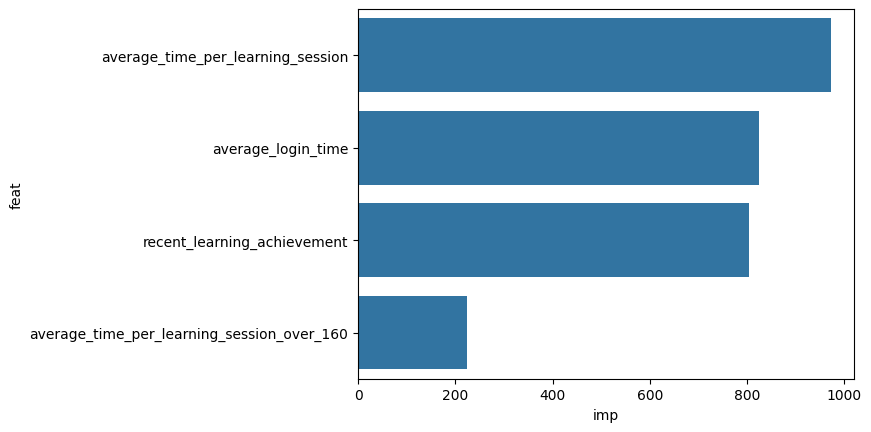

In [45]:
best_feature = None
best_score = 0
X1 = train.loc[:, ['average_time_per_learning_session_over_160', 'average_time_per_learning_session', 'recent_learning_achievement', 'average_login_time']]
# X1 = train.loc[:, ['average_time_per_learning_session','recent_learning_achievement','average_login_time']]
# X1 = train.loc[:,['average_time_per_learning_session', 'monthly_active_learning_days', 'total_completed_courses', 'preferred_difficulty_level']]
# cols.remove('average_time_per_learning_session')
# X1 = train.loc[:, cols]
y1 = train.loc[:,'target']
X1 = pd.get_dummies(X1)
K = 5
kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=39)
macrof1 = []
feat_imp = []
# auc_li = []
for idx, (train_idx, val_idx) in enumerate(kf.split(X1, y1)):
    print(idx)
    X_train = X1.iloc[train_idx,:]
    X_val = X1.iloc[val_idx,:]
    y_train = y1.iloc[train_idx]
    y_val = y1.iloc[val_idx]


    model2.fit(X_train, y_train)
    prediction = model2.predict(X_val)
    macrof1.append(f1_score(y_val, prediction, average = 'macro'))
    feat_imp.append(model2.feature_importances_)
    # auc_li.append(auc(y_val, prediction))
# print(macrof1)
print(f"macro f1 score : {np.mean(macrof1)}")
# print(f"auc score : {np.mean(auc_li)}")
tmp = pd.DataFrame({'feat': X_train.columns, 'imp' : sum(feat_imp)/K}).sort_values(by = 'imp', ascending=False)
sns.barplot(y = tmp.feat, x =  tmp.imp)
plt.show()

In [47]:
model2.get_params

<bound method LGBMModel.get_params of LGBMClassifier(colsample_bytree=0.8729349266800058, importance_type='gain',
               learning_rate=0.3942187948821839, max_depth=11,
               min_child_samples=9, min_split_gain=0.04430081438481328,
               n_estimators=1035, num_leaves=2047, objective='binary',
               random_state=39, reg_lambda=33.0848670909797,
               scale_pos_weight=0.6131634134537829, verbose=-1)>

### n_features : 3

best feature : ('average_time_per_learning_session', 'recent_learning_achievement', 'customer_inquiry_history')

best score : 0.5274635343440857

### n_features : 4



In [46]:
with open('./src/sample_submission.csv') as f:
    submission = pd.read_csv(f)
# best_params = {'learning_rate':0.2931348491046597,'n_estimators': 1425, 'num_leaves': 511, 'colsample_bytree': 0.5000263102652682, 'reg_lambda': 10.196712114510644, 'min_child_samples': 21}
model = LGBMClassifier(**best_params,
                       objective = 'binary',
                       scale_pos_weight = scale_pos_weight,
                       random_state = 39,
                       verbose = -1)
test['average_time_per_learning_session_over_160'] = test['average_time_per_learning_session'] > 160
model.fit(X, y)
pred = model.predict(pd.get_dummies(test[['average_time_per_learning_session_over_160', 'average_time_per_learning_session', 'recent_learning_achievement', 'average_login_time']]))
submission.target = pred
submission.to_csv('./src/submission.csv', index=False)

In [ ]:
model.get_params

<bound method LGBMModel.get_params of LGBMClassifier(colsample_bytree=0.8051943795866303,
               learning_rate=0.34798269140455584, max_depth=12,
               min_child_samples=6, min_split_gain=0.005869404717520133,
               n_estimators=1971, num_leaves=255, objective='binary',
               random_state=39, reg_lambda=103.36997124920711,
               scale_pos_weight=0.6131634134537829, verbose=-1)>